In [1]:
import os
from tqdm import tqdm

import config
import modules.dataloaders as detection_data_loader
import modules.metrics as metrics

import numpy as np
import torch
import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

import matplotlib.pyplot as plt

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
import onnx
import onnxruntime

# Check Model

In [3]:
brevitas_aimet_cpu_name = './onnx_models/w8a8b8__bed_detector___aimet__fixed_point__qcdq__CPU.onnx'
brevitas_aimet_cpu_model = onnx.load(brevitas_aimet_cpu_name)
onnx.checker.check_model(brevitas_aimet_cpu_name)

# Helper function to convert pytorch tensors to numpy. Useful to handle datatset output.

In [4]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# Detection Loaders

In [5]:
detection_loader = detection_data_loader.get_val_loader()


TEST DFire dataset
DFire Removed wrong images: 0
DFire Removed due to overlapping: 17
DFire Removed due to more than 10: 0

Test DFire dataset len: 183

TEST FASDD UAV dataset
FASDD Removed wrong images: 0
FASDD Removed due to overlapping: 20
FASDD Removed due to more than 10: 9

Test FASDD UAV dataset len: 171

TEST FASDD CV dataset
FASDD Removed wrong images: 0
FASDD Removed due to overlapping: 4
FASDD Removed due to more than 10: 0

Test FASDD CV dataset len: 196

Concatenate Test DFire and FASDD UAV datasets
Test dataset len: 354
Concatenate with FASDD CV dataset
Test dataset len: 550


# Evaluate Detector

In [6]:
map_metric = MeanAveragePrecision(
    box_format='xyxy',
    iou_thresholds=[config.IOU_THRESHOLD],
    class_metrics=True, # Enables separated metrics for each class
    #average='micro',
    extended_summary=False).to('cpu')

### Evaluation Function

In [7]:
def eval_detector_onnx(loader, model_name, score_thres):

    ort_session = onnxruntime.InferenceSession(model_name, providers=["CPUExecutionProvider"])

    map_metric.reset()
    
    loop = tqdm(loader, desc='Validating', leave=True)

    for batch_idx, (img, label) in enumerate(loop):

        for idx in range(config.BATCH_SIZE):
            
            ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img[idx].unsqueeze(dim=0))}
            out = ort_session.run(None, ort_inputs)
            
            # out of onnx session is a list: [out_tensor with batch dim] -> [ (1,12,7,7) ] 
            # -> out[0] = (1,12,7,7)
            # -> out[0][0] = (12,7,7)
            #print(f'Out type: {type(out[0])} - Output shape: {out[0].shape}')
            out = torch.tensor(np.array(out[0]))
            out = out.permute(0, 2, 3, 1)
            #print(f'Out shape after permute: {out.shape}')
            #print(f'Out shape after indexing: {out[0].shape}')
            
            # Label should be [xc, yc, w, h, score=1, smoke, fire] in 7x7 square
            #print(f'Label indexed shape: {label[idx].shape}')
            
        # Mean Average Precision
            target_boxes = metrics.get_true_boxes(label[idx].detach().to('cpu'))
            pred_boxes = metrics.get_pred_boxes(
                model_out = out[0].detach().to('cpu'),
                score_threshold=score_thres)
            map_metric.update(preds = pred_boxes, target = target_boxes)
    
    meanAP = map_metric.compute()
    map_metric.reset()

    print(f'Smoke -> AP: {meanAP["map_per_class"][0].item():.4f} - AR: {meanAP["mar_100_per_class"][0].item():.4f}')
    print(f'Fire -> AP: {meanAP["map_per_class"][1].item():.4f} - AR: {meanAP["mar_100_per_class"][1].item():.4f}')
    print(f'mAP: {meanAP["map_50"].item():.4f}')
    
    return (
        {'mAP': meanAP['map_50'].item(),
         'AP': [meanAP['map_per_class'][0].item(), meanAP['map_per_class'][1].item()],
         'AR': [meanAP['mar_100_per_class'][0].item(), meanAP['mar_100_per_class'][1].item()]
        }
    )

In [8]:
print("\n________________________________ Brevitas AIMET CPU: FULL _______________________________")
_ = eval_detector_onnx(
    detection_loader, 
    brevitas_aimet_cpu_name,
    0.2
)


________________________________ Brevitas AIMET CPU: FULL _______________________________


Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  1.89s/it]

Smoke -> AP: 0.6555 - AR: 0.6920
Fire -> AP: 0.5481 - AR: 0.5737
mAP: 0.6018


# Aladdin Metrics to Get Precision and Precision-Recall Curves

In [9]:
import modules.metrics_mAP_aladdin as aladdin_metrics

In [10]:
''' ============================
    Cell to Box Mask
============================ '''
cell2box_mask = torch.zeros((config.S, config.S, 2))
for i in range(config.S):
    for j in range(config.S):
        cell2box_mask[i,j,0] = j
        cell2box_mask[i,j,1] = i  

### Aladdin mAP modified for ONNX detection with thresholds

In [11]:
def aladdin_get_bboxes(
    loader,
    detector_model_name,
    S=config.S,
    B=config.B,
    C=config.C,
    mask=cell2box_mask,
    device='cpu',
    iou_threshold=0.5,
    score_thres=0.2,
    box_format="midpoint"):
    
    '''
    
    Return:
        - all_pred_boxes
        - all_true_boxes
        Format: [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
    '''
    
    detect_session = onnxruntime.InferenceSession(detector_model_name, providers=["CPUExecutionProvider"])
    
    
    all_pred_boxes = []
    all_true_boxes = []

    # Original Code
    # make sure model is in eval before get bboxes
    #model.eval()
    train_idx = 0

    loop = tqdm(loader, desc='Get Boxes', leave=True)
    for batch_idx, (imgs, labels) in enumerate(loop):
        # Original Code
        # Inference in GPU. Move tensor to CPU in outcell_2_outboxes
        # imgs = imgs.to(device)
        # labels = labels.to(device)


        for idx in range(config.BATCH_SIZE):
            
            detect_inputs = {detect_session.get_inputs()[0].name: to_numpy(imgs[idx].unsqueeze(dim=0))}
            out = detect_session.run(None, detect_inputs)
            out = torch.tensor(np.array(out[0]))
            out = out.permute(0, 2, 3, 1)         
            
            # Original Code
            # with torch.no_grad():
            #     predictions = model(imgs)

            # Original Code
            # Remove Permute from the model
            #predictions = predictions.permute(0, 2, 3, 1) # Original Code

            #batch_size = imgs.shape[0] # Original Code

            true_bboxes = aladdin_metrics.outcell_2_outboxes(
                out_cells=labels[idx].unsqueeze(dim=0), 
                S=S, B=B, C=C, 
                mask=mask, 
                device='cpu', # Changed to cpu
                is_pred=False)
            bboxes = aladdin_metrics.outcell_2_outboxes(
                out_cells=out, 
                S=S, B=B, C=C, 
                mask=mask, 
                device='cpu', # Changed to cpu
                is_pred=True)

            for idx in range(1): # Only 1 image every time, due to ONNX prediction in CPU
                nms_boxes = aladdin_metrics.nms_yv1_getBBoxes(
                    bboxes[idx],
                    iou_threshold=iou_threshold,
                    threshold=score_thres,
                    box_format=box_format, # Midpoint, to use iou_tensor inside
                )


                # Plot some examples
                #if batch_idx == 0 and idx == 0:
                #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
                #    print(nms_boxes)

                for nms_box in nms_boxes:
                    all_pred_boxes.append([train_idx] + nms_box)

                for box in true_bboxes[idx]:
                    # many will get converted to 0 pred, as bboxes have Conf = 1 and the rest are 0
                    if box[1] > score_thres:
                        all_true_boxes.append([train_idx] + box)

                train_idx += 1

    #model.train()
    return all_pred_boxes, all_true_boxes

# Function to Print mAP metrics

In [12]:
def print_metrics(mAP_metrics):
    mAP, avg_prec, cls_prec, cls_rec = mAP_metrics
    
    mAP_str = "mAP @0.50"
    smoke = "Smoke"
    fire = "Fire"
    
    print(f'{mAP_str:<12}' + f'{mAP:.4f}')
    print('Average Precision')
    print(f'- {smoke:<10}' + f'{avg_prec[0]:.4f}')
    print(f'- {fire:<10}' + f'{avg_prec[1]:.4f}')
    print('Class Precision')
    print(f'- {smoke:<10}' + f'{cls_prec[0]:.4f}')
    print(f'- {fire:<10}' + f'{cls_prec[1]:.4f}')  
    print('Class Recall')
    print(f'- {smoke:<10}' + f'{cls_rec[0]:.4f}')
    print(f'- {fire:<10}' + f'{cls_rec[1]:.4f}')
    print('Class F1-Score')
    smoke_f1 = 2 * (cls_prec[0] * cls_rec[0]) / (cls_prec[0] + cls_rec[0])
    fire_f1 = 2 * (cls_prec[1] * cls_rec[1]) / (cls_prec[1] + cls_rec[1])
    print(f'- {smoke:<10}' + f'{smoke_f1:.4f}')
    print(f'- {fire:<10}' + f'{fire_f1:.4f}')

## Score Thres 

In [13]:
score_thres_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [14]:
def get_f1_metrics(loader, detector_model_name, score_list):
    
    f1_smoke_list = []
    f1_fire_list = []
    f1_mean_list = []
    
    for score in score_list:
        pred_boxes, true_boxes = aladdin_get_bboxes(
            loader,
            detector_model_name = detector_model_name,
            score_thres = score)
        _, _, precision, recall = aladdin_metrics.mAP(
            log_path=None,
            pred_boxes=pred_boxes,
            true_boxes=true_boxes)
        f1_smoke = (2*precision[0]*recall[0])/(precision[0] + recall[0])
        f1_fire = (2*precision[1]*recall[1])/(precision[1] + recall[1])
        f1_mean = (f1_smoke + f1_fire)/2
        f1_smoke_list.append(f1_smoke)
        f1_fire_list.append(f1_fire)
        f1_mean_list.append(f1_mean)
        
    return f1_smoke_list, f1_fire_list, f1_mean_list

In [15]:
f1_metrics = get_f1_metrics(detection_loader, brevitas_aimet_cpu_name, score_thres_list)

mAP:@.5: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 67.91it/s]


In [16]:
print(f1_metrics)

([0.5287671138997999, 0.6275167900918407, 0.6666666757932757, 0.6880907542289574, 0.6980392104178744, 0.7172131284163327, 0.71848740593366, 0.7198275792679342, 0.7072072015163203, 0.687350827307053, 0.634517769117615, 0.5698924900593269, 0.45481051407680767], [0.4883720920204811, 0.5680934062979472, 0.5979381342676142, 0.623376644075892, 0.6396396413128601, 0.6407322754851508, 0.6524822892928118, 0.6618705127389072, 0.6600496169216583, 0.6498740511232683, 0.6342711136253933, 0.578378391315068, 0.5371428699717229], [0.5085696029601405, 0.5978050981948939, 0.6323024050304449, 0.6557336991524247, 0.6688394258653673, 0.6789727019507417, 0.6854848476132359, 0.6908490460034207, 0.6836284092189893, 0.6686124392151607, 0.6343944413715041, 0.5741354406871975, 0.4959766920242653])


In [27]:
smoke_f1 = [0] + f1_metrics[0] + [0]
fire_f1 = [0] + f1_metrics[1] + [0]
mean_f1 = [0] + f1_metrics[2] + [0]

score_thres_list = [0] + score_thres_list + [1]

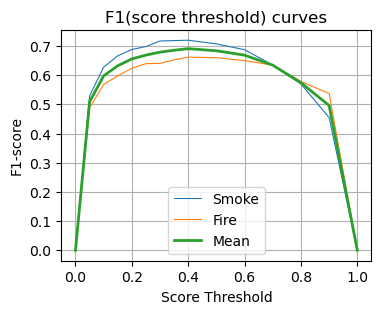

In [38]:
plt.subplots(figsize=(4,3))
plt.plot(score_thres_list, smoke_f1, label="Smoke", linewidth=0.8)
plt.plot(score_thres_list, fire_f1, label="Fire", linewidth=0.8)
plt.plot(score_thres_list, mean_f1, label="Mean", linewidth=2)
plt.grid()
plt.xlabel("Score Threshold")
plt.ylabel("F1-score")
plt.legend()
plt.title("F1(score threshold) curves")
plt.show()

In [40]:
print("\n________________________________ Brevitas AIMET CPU: FULL _______________________________")
eval_metrics = eval_detector_onnx(
    detection_loader, 
    brevitas_aimet_cpu_name,
    0.8
)


________________________________ Brevitas AIMET CPU: FULL _______________________________


Validating: 100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  1.91s/it]

Smoke -> AP: 0.4006 - AR: 0.4030
Fire -> AP: 0.4208 - AR: 0.4263
mAP: 0.4107


In [41]:
print(eval_metrics)

{'mAP': 0.41070422530174255, 'AP': [0.4006004333496094, 0.42080801725387573], 'AR': [0.4030418395996094, 0.42629483342170715]}


In [42]:
from scipy.interpolate import interp1d

In [44]:
cubic_interploation_model = interp1d(np.array(score_thres_list), np.array(smoke_f1), kind="cubic")
xs = np.linspace(0, 1, 500)
ys = cubic_interploation_model(xs)

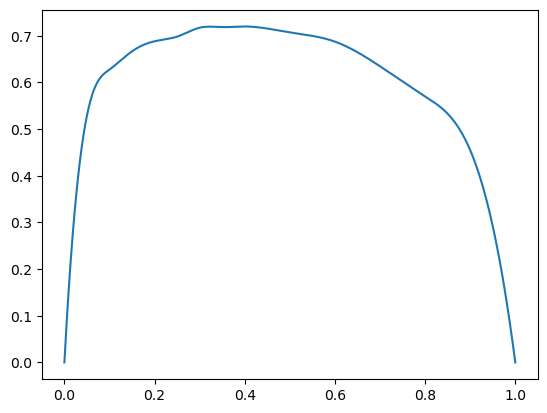

In [45]:
plt.plot(xs, ys)
plt.show()